# US Arrests Dataset

### Data Source

This dataset provides statistics on arrests per 100,000 residents for assault, murder, and rape across 50 US states in 1973. It also includes the percentage of the population residing in urban areas. 

### Dataset Attributes

The US Arrests dataset contains the following attributes:
- **City**: The name of the state.
- **Murder**: Arrests per 100,000 residents for murder.
- **Assault**: Arrests per 100,000 residents for assault.
- **UrbanPop**: Percentage of the population living in urban areas.
- **Rape**: Arrests per 100,000 residents for rape.

### Objective

The objective of this analysis is to perform a comprehensive investigation of the US Arrests dataset using advanced statistical methods. The report aims to:

- Conduct **Principal Component Analysis (PCA)** to identify the key components that explain the variance in the dataset, and interpret the significance of the underlying variables.
  
- Compare two clustering methods, **Hierarchical Clustering** and **K-Means Clustering**, to classify US states based on their arrest statistics and urban population. This analysis will aim to identify commonalities and differences between the clusters, and uncover any meaningful patterns or insights from the clustering results.

The analysis will detail the steps involved, including data preprocessing, the rationale behind each method, and the interpretation of the outcomes.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# %matplotlib inline ensures that plots appear in the notebook immediately after the code cell is run
%matplotlib inline 

# Machine learning libraries for scaling, dimensionality reduction, and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


## Load and Explore Data

In [2]:
# Load the UsArrests dataset
try:
    us_arrests_df = pd.read_csv("UsArrests.csv")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'UsArrests.csv' was not found.")
    us_arrests_df = pd.DataFrame()

# Display the first few rows of the DataFrame if it is not empty
if not us_arrests_df.empty:
    display(us_arrests_df.head())
else:
    print("DataFrame is empty. Please check the file path and try again.")


Dataset loaded successfully!


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
# Rename 'City' column to 'State'
us_arrests_df.rename(columns={'City': 'State'}, inplace=True)

# Display the first few rows of the updated DataFrame
display(us_arrests_df.head())


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


### Best Practice for PCA:
Use the raw individual features (Murder, Assault, UrbanPop, Rape) to let PCA determine the optimal combination of these features to explain the variance. This is a more accurate way to perform dimensionality reduction.

Therefore I will not be creating new columns. I will proceed with the original features for the PCA analysis.

In [4]:
# To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Generate descriptive statistics for the numerical columns in the dataset
us_arrests_df.describe()


,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.07
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.18
max,17.40,337.00,91.00,46.00


### Assumptions:

- The **mean values** for each crime indicate that, on average, there are 7.79 murders, 170.76 assaults, and 21.23 rapes per 100,000 residents, while 65.54% of the population lives in urban areas.
- The **standard deviations** suggest that assaults have the highest variability across states, whereas rape and murder rates exhibit less variation.
- **Minimum and maximum values** highlight the wide range of crime rates and urbanization, with murder rates ranging from 0.8 to 17.4 and assault rates ranging from 45 to 337. 
- The **25th and 75th percentiles** show that half of the states have assault rates between 109 and 249 per 100,000, while 50% of states have an urban population between 54.5% and 77.75%.

These statistics offer initial insights into the spread and variability of the arrest data, setting the stage for further investigation using PCA and clustering methods to identify underlying patterns and groupings in the data.

Scaling the data is necessary because the variables in the dataset (like **Assault** and **Murder**) have significantly different means and standard deviations. Methods like **PCA** and **K-Means** are sensitive to these variations, and without scaling, larger values could disproportionately affect the analysis. By standardizing the data, we ensure that all variables contribute equally to the results, leading to more accurate and balanced conclusions in both PCA and clustering.

In [5]:
# Display information about the DataFrame, including data types and non-null counts
us_arrests_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


### Assumptions:

- The dataset consists of **50 entries**, each representing a US state, with **5 columns**.
- The data types show that **'Murder'** and **'Rape'** are stored as floating-point numbers (`float64`), while **'Assault'** and **'UrbanPop'** are stored as integers (`int64`).
- The **'State'** column is an object type, indicating that it holds string values for the state names.
- There are **no missing values**, as all 50 entries for each column are non-null.

This clean dataset ensures that no immediate data preprocessing (such as handling missing values) is required, allowing for smooth implementation of PCA and clustering methods to uncover patterns and relationships between crime rates and urbanization across the US states.

In [6]:
# Confirm no rows with missing data
missing_data_rows = us_arrests_df[us_arrests_df.isna().any(axis=1)]

if not missing_data_rows.empty:
    display(missing_data_rows)
    print(f"Number of rows with missing data: {len(missing_data_rows)}")
else:
    print("No rows with missing data found.")


No rows with missing data found.


In [7]:
# Number of rows before removing duplicates
initial_row_count = us_arrests_df.shape[0]
print(f"Number of rows in dataset: {initial_row_count}")

# Identify and display duplicate rows
duplicates = us_arrests_df[us_arrests_df.duplicated()]

if not duplicates.empty:
    display(duplicates)
    duplicate_count = len(duplicates)
    print(f"Number of duplicate rows: {duplicate_count}")
    
    # Remove duplicates
    us_arrests_df = us_arrests_df.drop_duplicates()
    print("Duplicates have been removed.")
    
    # Number of rows after removing duplicates
    final_row_count = us_arrests_df.shape[0]
    print(f"Number of rows after removing duplicates: {final_row_count}")
else:
    print("No duplicate rows found.")


Number of rows in dataset: 50
No duplicate rows found.


In [8]:
# Selecting only the columns relevant to the analysis
clean_df = us_arrests_df[['Murder', 'Assault', 'Rape', 'UrbanPop']]

# Display the dimensions of the DataFrame (number of rows, number of columns)
clean_df.shape


(50, 4)

## Preprocessing and Feature Selection

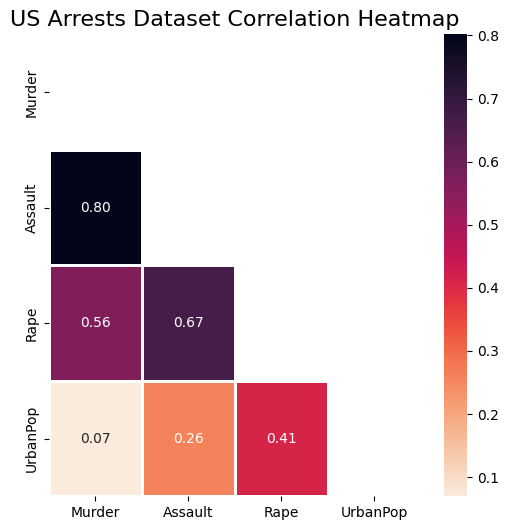

In [9]:
def corr_heatmap(df, cmap='rocket_r', title="Correlation Heatmap"):
    """
    Function to plot a correlation heatmap for a given dataframe.
    It masks the upper triangle of the heatmap to avoid redundancy.
    
    Parameters:
    df : DataFrame
        The input dataframe for which the correlation heatmap is to be plotted.
    cmap : str (optional)
        The colormap or color palette to be used for the heatmap. Default is 'rocket_r'.
    title : str (optional)
        The title for the heatmap. Default is 'Correlation Heatmap'.
    """
    # Get correlation matrix of the dataframe
    corrs = df.corr()

    # Plot figure size
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create a mask for the upper triangle to avoid redundant information
    matrix = np.triu(corrs)

    # Generate the heatmap with annotations for the correlation coefficients
    sns.heatmap(corrs, cmap=cmap, annot=True, fmt=".2f", mask=matrix, linewidths=2, ax=ax)

    # Add a title to the heatmap
    ax.set_title(title, fontsize=16)

# Call the function on the clean_df with custom colormap and title
corr_heatmap(clean_df, cmap='rocket_r', title="US Arrests Dataset Correlation Heatmap")


### Assumptions:

- **Strong positive correlation** between **Murder and Assault (0.80)**: States with higher murder rates tend to have higher assault rates, which aligns with the intuition that violent crimes might cluster together.
- **Moderate positive correlation** between **Rape and Assault (0.67)** and **Rape and Murder (0.56)**: States with higher rates of rape also tend to have higher rates of other violent crimes, indicating potential shared socio-economic or environmental factors influencing these crimes.
- **Weak correlation between UrbanPop and other variables**: The low correlation between **UrbanPop** and crime rates (0.07 to 0.41) suggests that the percentage of urban population does not have a significant linear relationship with crime rates.

### Impact on PCA and Clustering:
- The strong correlations between crime variables (Murder, Assault, and Rape) are helpful for **PCA**, as it indicates redundancy in the data that can be reduced to fewer principal components, capturing most of the variance.
- For **clustering**, the moderate to strong correlations among crime variables will likely lead to clusters that reflect these relationships, grouping states with similar crime profiles.

These insights suggest that PCA will be effective in reducing the dimensionality of the dataset, and clustering techniques should reveal meaningful groupings based on crime patterns.

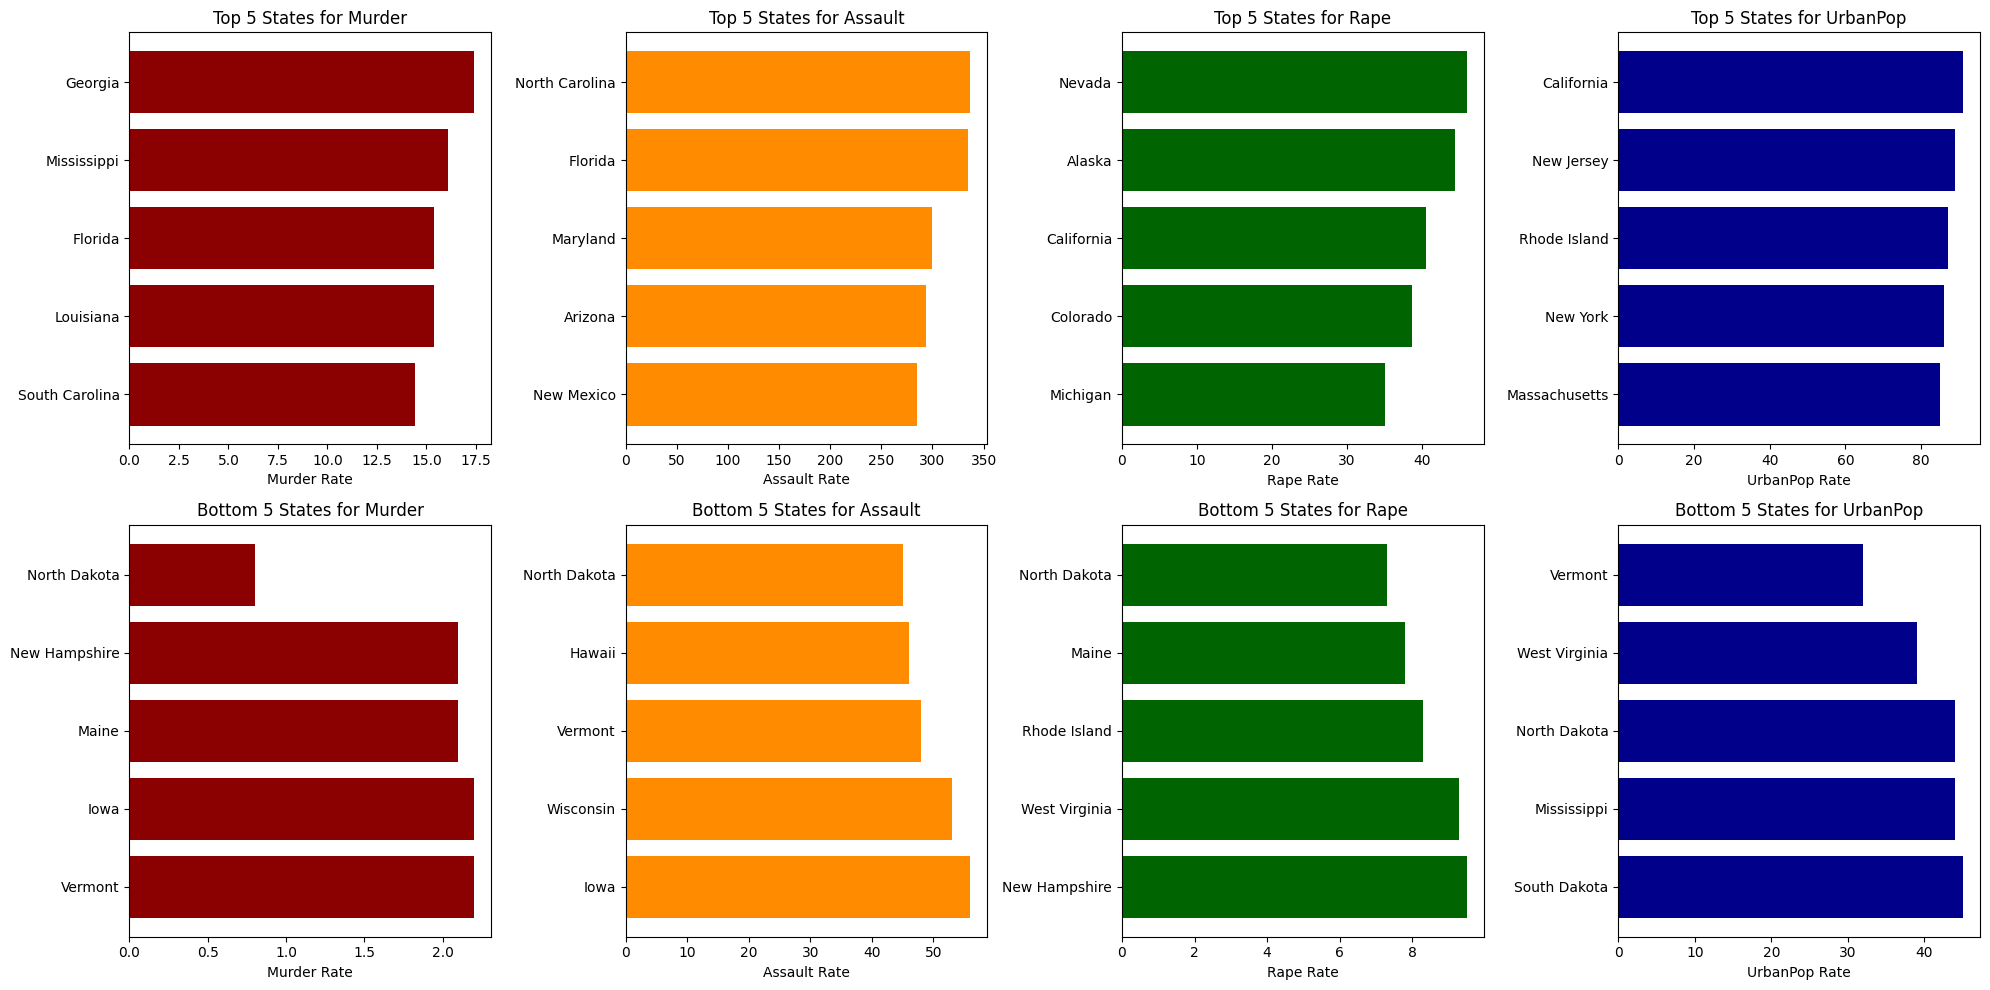

In [10]:
# List of crime types and colors for plotting
crime_types = ['Murder', 'Assault', 'Rape', 'UrbanPop']
colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue']

# Create a figure with subplots for both top and bottom crime rankings
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows: one for top 5, one for bottom 5

# Loop through each crime type and generate both top and bottom plots
for index, crime in enumerate(crime_types):
    # Get the top 5 and bottom 5 states for the current crime type
    top_5_states = us_arrests_df.sort_values(by=crime, ascending=False).head(5)
    bottom_5_states = us_arrests_df.sort_values(by=crime, ascending=True).head(5)
    
    # Plot top 5 states by crime rate (first row)
    axes[0, index].barh(top_5_states['State'], top_5_states[crime], color=colors[index])
    axes[0, index].set_title(f'Top 5 States for {crime}')
    axes[0, index].set_xlabel(f'{crime} Rate')
    axes[0, index].invert_yaxis()  # Highest value at the top
    
    # Plot bottom 5 states by crime rate (second row)
    axes[1, index].barh(bottom_5_states['State'], bottom_5_states[crime], color=colors[index])
    axes[1, index].set_title(f'Bottom 5 States for {crime}')
    axes[1, index].set_xlabel(f'{crime} Rate')
    axes[1, index].invert_yaxis()  # Highest value at the top

# Adjust layout to prevent overlap
plt.tight_layout()


### Assumptions:

- **Top 5 States** for each crime type show clear regional variations in crime rates:
  - **Georgia** has the highest murder rate, while **North Carolina** leads in assaults, and **Nevada** in rape.
  - **California** ranks highest in urbanization.

- **Bottom 5 States** for each crime type indicate that states such as **North Dakota** and **Vermont** consistently have the lowest rates for multiple crime types, suggesting lower crime overall in these regions.
  - These states also rank lower in urbanization.

This analysis highlights how crime rates differ significantly across the US, with states having varying levels of murder, assault, rape, and urban population density. The stark differences may reveal potential patterns when conducting **Principal Component Analysis (PCA)** and clustering methods to group similar states based on these factors.

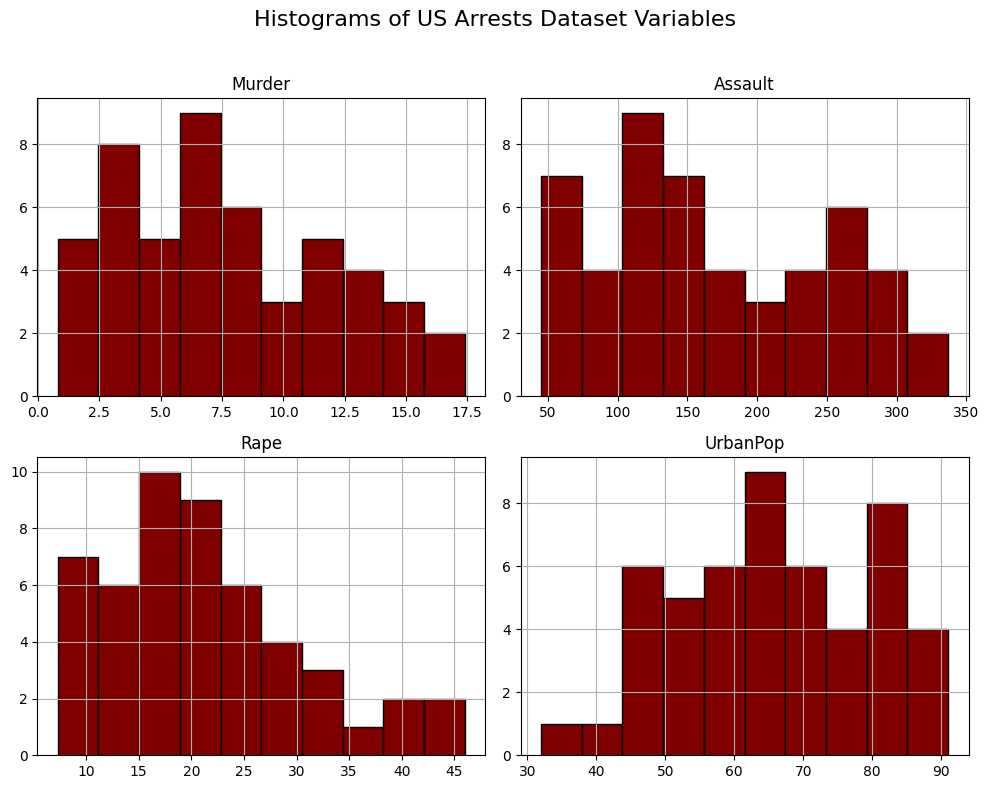

In [11]:
# Plotting histograms for each variable in the dataset
clean_df.hist(bins=10, figsize=(10, 8), color='maroon', edgecolor='black')

# Adding title for the overall figure
plt.suptitle('Histograms of US Arrests Dataset Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include title


### Assumptions:

- **Murder and Rape**: These variables show a skewed distribution, with most states having lower rates, while a few states have significantly higher rates.
- **Assault**: The distribution of assault rates is more spread out, with a peak around 100–150 arrests per 100,000 residents and some states having much higher rates.
- **UrbanPop**: The urban population percentage is relatively normally distributed, though with a slightly skewed distribution, indicating that most states have moderate to high urbanization, but a few states have lower percentages.

These histograms highlight the variability in crime rates and urbanization across the states. This variability is important for the subsequent **PCA** and clustering analyses, as it indicates that dimensionality reduction and classification may reveal distinct patterns in state-level crime and urbanization data.

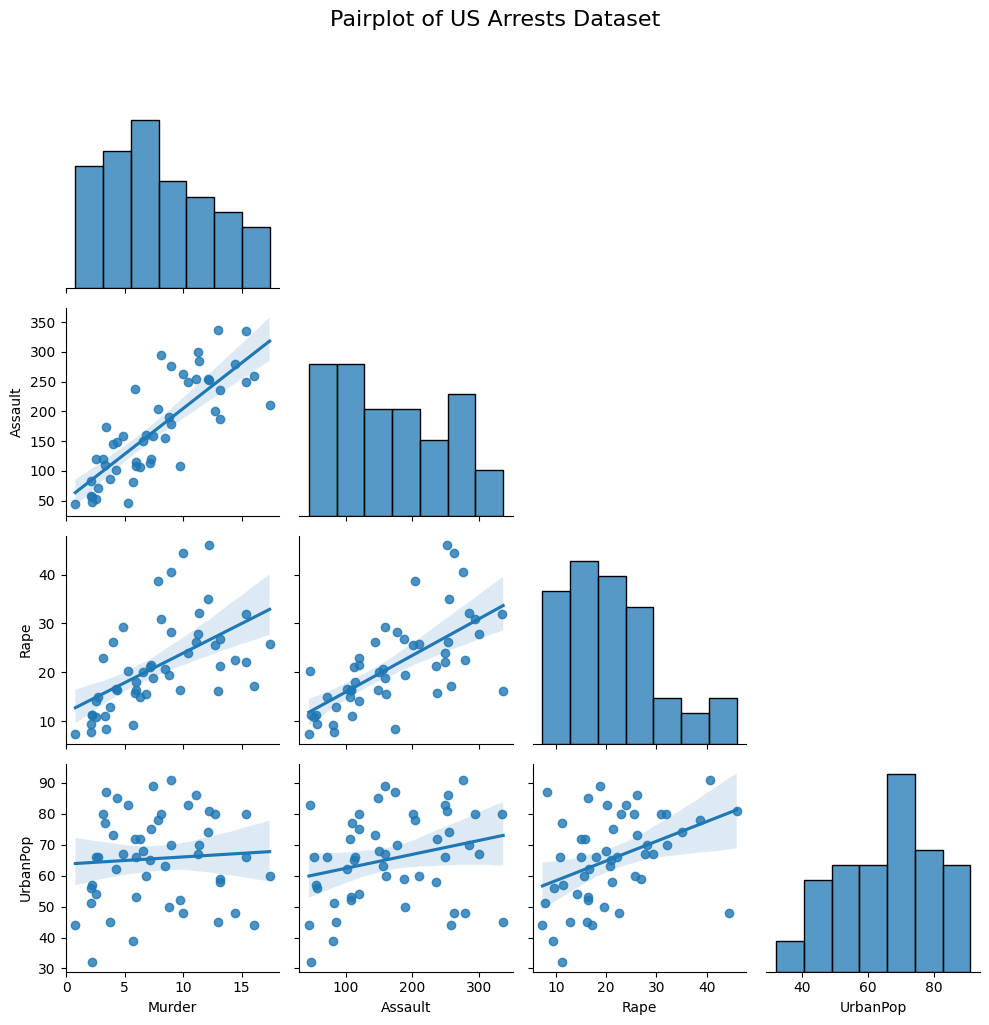

In [12]:
# Plot pairplot with histograms for diagonal plots and scatter plots for other pairs
sns.pairplot(clean_df, diag_kind='hist', corner=True, kind='reg')

# Adding a title to the entire figure
plt.suptitle('Pairplot of US Arrests Dataset', y=1.02, fontsize=16)

# Adjust layout 
plt.tight_layout()


### Assumptions:

- The **scatter plots** between **Murder**, **Assault**, and **Rape** show positive relationships, with higher rates of one crime often corresponding to higher rates of the others.
- **UrbanPop** appears less correlated with the crime variables, as the scatter plots between **UrbanPop** and the other variables show no clear trend.
- The **diagonal histograms** highlight the distribution of each variable, indicating that most states have moderate crime rates, with a few outliers having significantly higher rates.

These insights align with the objective of using PCA and clustering to explore the relationships between crime rates and identify patterns across different states.

# Apply PCA

In [13]:
# Standardize the features to ensure that they are on the same scale
scaler = StandardScaler()
X = scaler.fit_transform(clean_df.values)

# Print the shape of the selected data to confirm its size
print('Data size:')
print(X.shape)


Data size:
(50, 4)


For the US Arrests dataset, using **StandardScaler** ensures that PCA captures the **true structure** of the data by equalizing the contributions of all features, regardless of their original scales.

Explained variance ratio: [0.62006039 0.24744129 0.0891408  0.04335752]
Cumulative variance ratio: [0.62006039 0.86750168 0.95664248 1.        ]


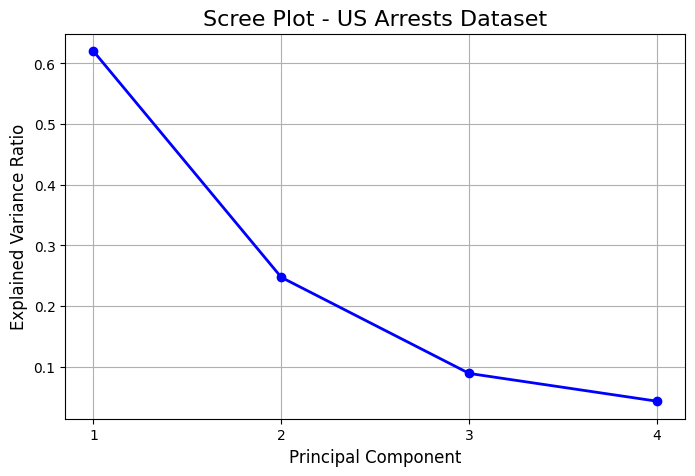

In [14]:
# 4 Components for each feature in the dataset
pca = PCA(n_components=4)
pca.fit(X)

# Explained variance ratios for the scree plot
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Print cumulative variance to determine how many components to retain
print("Explained variance ratio:", explained_variance)
print("Cumulative variance ratio:", cumulative_variance)

# Plot the scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot - US Arrests Dataset', fontsize=16)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)


### Assumptions:

- The first principal component (PC1) explains the largest portion of the variance, around **62%**.
- The second principal component (PC2) explains an additional **24.7%**, making the cumulative variance explained by the first two components around **86.7%**.
- The third and fourth components explain much less variance (around 8.9% and 4.2%).

Based on the **elbow** in the scree plot, it is reasonable to retain **2 or 3 components** for further analysis, as they capture most of the dataset's variance. This selection is effective for reducing dimensionality while maintaining essential information.

Text(0.5, 1.0, 'Cumulative Explained Variance')

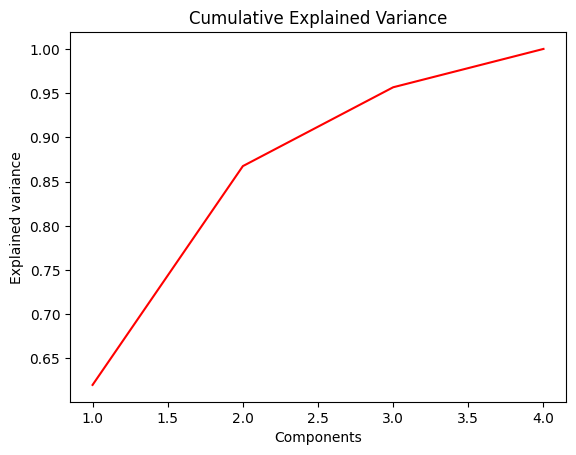

In [15]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")


### Assumptions:

- **PC1 (Principal Component 1)** explains about **62%** of the variance in the dataset, meaning it captures most of the important information related to crime rates (Murder, Assault, and Rape).
- **PC2** increases the explained variance to approximately **87%**, indicating that both components together capture the majority of the meaningful variation in the data (including urbanization through UrbanPop).
- **PC3 and PC4** add less variance, bringing the cumulative total close to **100%**, but their contribution is smaller and may not be as critical for further analysis.

Using the first **two components** (PC1 and PC2) is sufficient to capture most of the variation in the data (around 87%). This supports the use of these two components for clustering and dimensionality reduction, as they represent the key patterns in the dataset related to crime rates and urbanization.

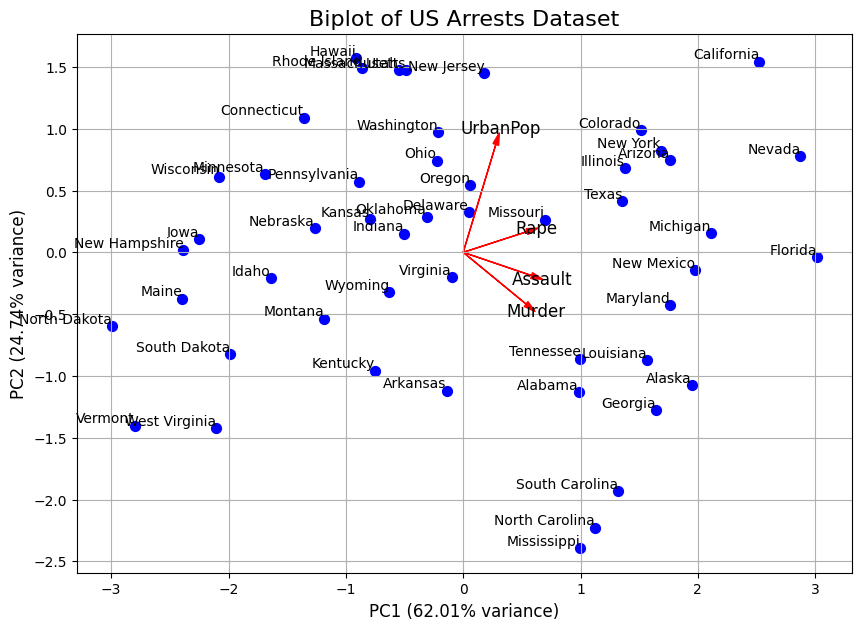

In [16]:
# Function to plot a biplot for PCA
def biplot(pca, X, labels, states):
    """
    Creates a biplot for the first two principal components with state names.
    
    Parameters:
    - pca: PCA object after fitting the data.
    - X: Transformed data (principal components).
    - labels: Feature names for the original data.
    - states: Names of the states corresponding to each data point.
    """
    # Scatter plot of the first two principal components
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c='blue', s=50)
    
    # Add state names next to each point
    for i, state in enumerate(states):
        plt.text(X[i, 0], X[i, 1], state, fontsize=10, ha='right', va='bottom', color='black')
    
    # Plot arrows for feature vectors (PCA loadings)
    for i, label in enumerate(labels):
        plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                  color='red', head_width=0.05, head_length=0.1)
        plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, 
                 label, color='black', ha='center', va='center', fontsize=12)
    
    # Labels and title
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)", fontsize=12)
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)", fontsize=12)
    plt.title('Biplot of US Arrests Dataset', fontsize=16)
    plt.grid(True)
    plt.show()

# Extract the state names from the DataFrame
states = us_arrests_df['State']

# Call the biplot function with state names
biplot(pca, pca.transform(X), clean_df.columns, states)


### Assumptions:
  
- **Feature Loadings**: 
  - **Murder**, **Assault**, and **Rape** are closely aligned, indicating that these crime types are strongly correlated and likely drive much of the variability along PC1.
  - **UrbanPop** points in a different direction, indicating it has less correlation with the crime variables and contributes more to PC2.

### Clustering Insights:
- While distinct clusters are not immediately visible, we do observe a spread of states along both PC1 and PC2.
  - **States far along PC1** (to the right) likely have higher rates of violent crime (Murder, Assault, Rape).
  - **States far along PC2** (above) may be characterized by higher urbanization (UrbanPop) relative to other states.
  
- The separation of points suggests that **clustering methods** like **K-Means** or **Hierarchical Clustering** could reveal meaningful groupings, possibly distinguishing high-crime, high-urbanization states from others with lower rates of both.

The biplot suggests that PCA has effectively reduced the dataset's dimensionality and could aid in clustering states based on crime rates and urban population.

In [17]:
# Perform PCA with the appropriate number of components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X)  # X is the standardized data

# Transform the components into a pandas DataFrame
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Display a random sample of 5 rows of the principal components
pca_df.sample(5)


,PC1,PC2,PC3
32,1.12,-2.23,-0.86
39,1.32,-1.93,-0.30
44,-2.80,-1.40,0.84
20,-0.49,1.47,-0.61
15,-0.80,0.27,0.03


These components help distinguish patterns in the dataset, and PCA allows for dimensionality reduction while retaining essential variance, setting the stage for clustering or further analysis of state-level crime and urbanization profiles.

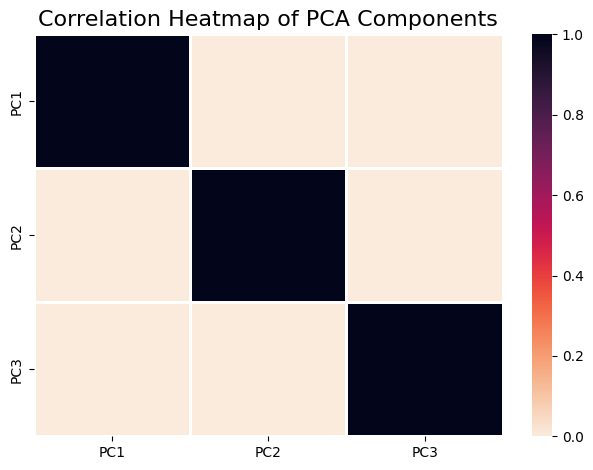

In [18]:
# Plot the correlation heatmap for the PCA components
ax = sns.heatmap(pca_df.corr(), cmap='rocket_r', linewidths=1)

# Add a title to the heatmap
ax.set_title('Correlation Heatmap of PCA Components', fontsize=16)

# Adjust the layout
plt.tight_layout()


### Assumptions:

- **No correlation between components**: The heatmap shows no correlation (all values near 0) between the principal components (PC1, PC2, PC3).
  
- This confirms that each principal component contributes unique information, supporting the goal of dimensionality reduction while maintaining the distinct patterns in the dataset, crucial for further clustering or analysis.

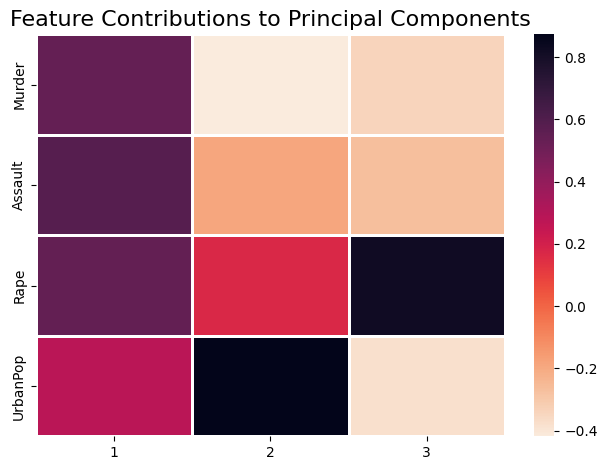

In [19]:
# Create a DataFrame for PCA components with feature names as columns and components as rows
components = pd.DataFrame(pca.components_, columns=clean_df.columns, index=range(1, 3 + 1)).transpose()

# Plot a heatmap to visualize the contribution of each feature to each principal component
heatmap_ax = sns.heatmap(components, cmap='rocket_r', linewidths=1)

# Add a title to the heatmap
heatmap_ax.set_title('Feature Contributions to Principal Components', fontsize=16)

# Ensure layout fits without overlap
plt.tight_layout()  


### Assumptions:

- **PC1**:
  - Strongly influenced by **Murder**, **Assault**, and **Rape** (high positive contributions).
  - Represents overall violent crime rates, explaining why PC1 captures most of the variance (around 62%).
  
- **PC2**:
  - Primarily influenced by **UrbanPop** (urban population), with weaker contributions from other crime features.
  - PC2 likely captures differences in urbanization, explaining about 24.7% of the variance.
  
- **PC3**:
  - Dominated by **Rape** with some smaller contributions from other variables.
  - Captures more nuanced patterns not explained by the first two components, with a smaller variance contribution (about 8.9%).

This aligns well with the objective of PCA for dimensionality reduction, ensuring the most significant data patterns are preserved for clustering or further analysis. The PCA transformation has effectively removed redundancy by summarizing highly correlated features into fewer dimensions, 

In [20]:
# Adjust precision to display more decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Access the absolute values of the components for PC1 and PC2
pc1 = abs(pca.components_[0])
pc2 = abs(pca.components_[1])

# Create a DataFrame to hold feature names and their importance in PC1 and PC2
feat_df = pd.DataFrame()
feat_df["Features"] = clean_df.columns
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2

# Sort by PC1 importance for clarity (optional)
feat_df = feat_df.sort_values(by="PC1 Importance", ascending=False)

# Display the feature importance DataFrame
feat_df


,Features,PC1 Importance,PC2 Importance
1,Assault,0.583,0.188
2,Rape,0.543,0.167
0,Murder,0.536,0.418
3,UrbanPop,0.278,0.873


### Assumptions:

This analysis aligns with the earlier PCA results, where PC1 represented overall crime rates **Assault (0.583)**, **Rape (0.543)**, and **Murder (0.536)** and PC2 reflected urbanization **UrbanPop (0.873)**. These components help separate states based on their crime profiles and population distribution, supporting the objective of identifying meaningful patterns in the data.

# Cluster Analysis

## Hierarchical Clustering

In [21]:
# Select the PCA dataframe for clustering analysis
X = pca_df

# Print the shape of the selected data to confirm its size
print('Data size:')
print(X.shape)


Data size:
(50, 3)


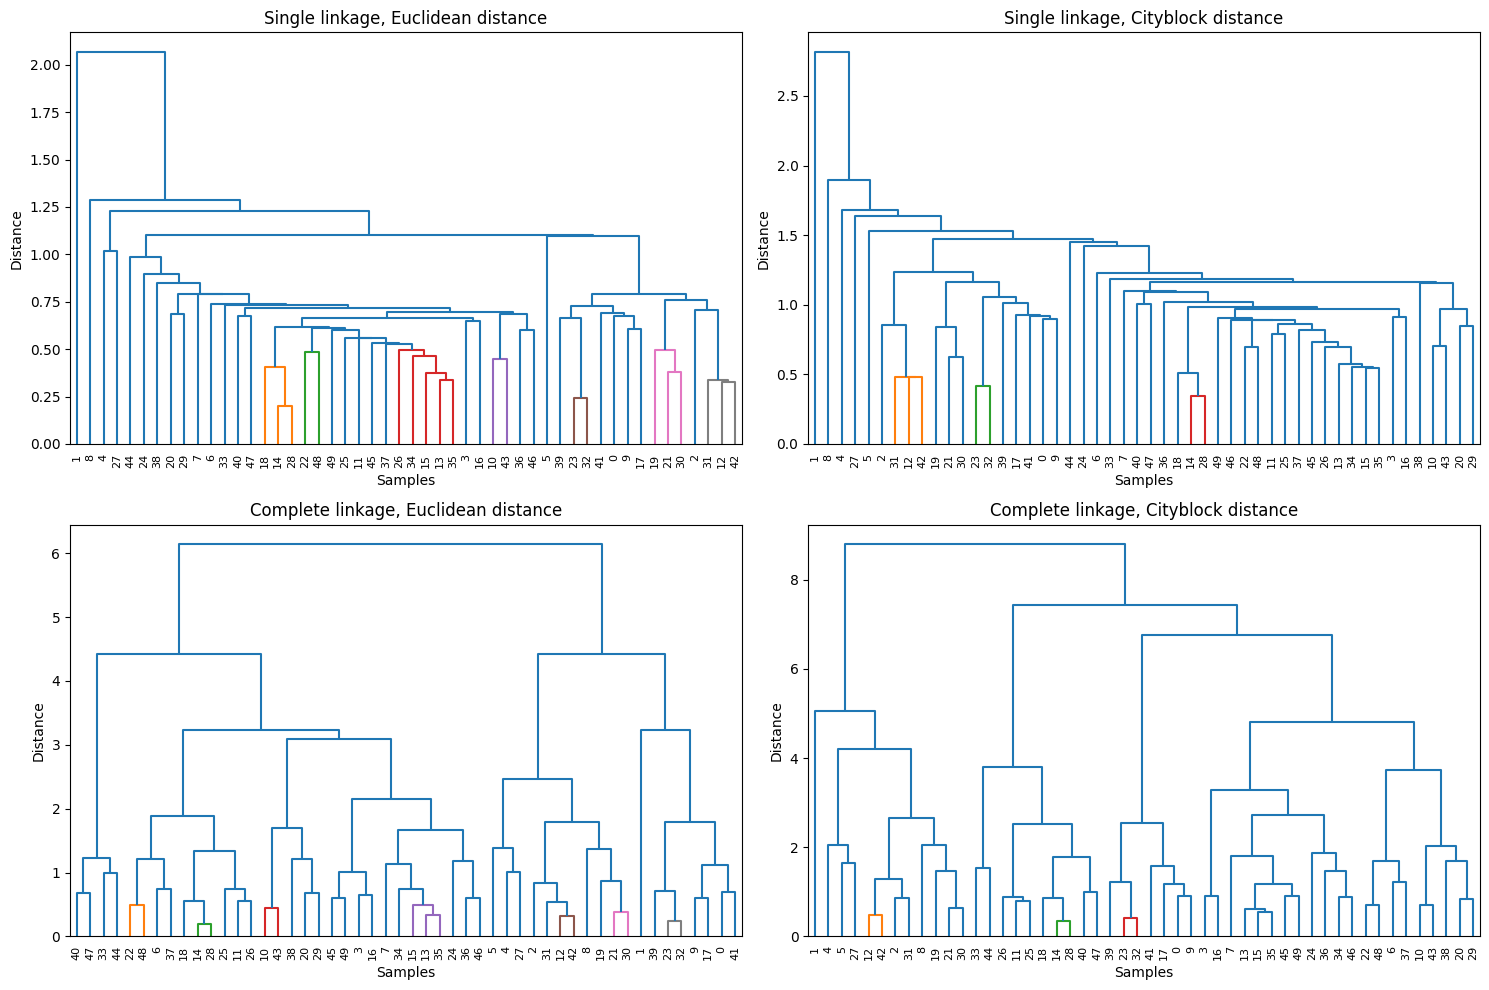

In [22]:
# Define linkage methods and distance metrics to be used for hierarchical clustering
methods = ['single', 'complete']
metrics = ['euclidean', 'cityblock']

# Generate dendrograms for each combination of linkage method and distance metric
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        # Perform hierarchical clustering using the specified linkage method and distance metric
        Z = linkage(X, method=method, metric=metric)
        
        # Plot the dendrogram for the current clustering result
        dendrogram(Z, ax=axes[i, j], color_threshold=0.5)
        
        # Set a title for each subplot indicating the linkage method and distance metric used
        axes[i, j].set_title(f'{method.capitalize()} linkage, {metric.capitalize()} distance')
        
        # Optional: Set axis labels to make the plot clearer
        axes[i, j].set_xlabel('Samples')
        axes[i, j].set_ylabel('Distance')

# Adjust layout to avoid overlap and improve presentation
plt.tight_layout()


**Complete Linkage with Euclidean Distance** is likely the best choice because:
  - It provides more distinct, evenly distributed clusters.
  - It avoids the chaining problem seen with single linkage.
  - Euclidean distance captures the true geometric distance, making it a good fit for the PCA-transformed data.

  To determine the optimal number of clusters for hierarchical clustering, you can use several methods:

Based on the **Complete Linkage, Euclidean Distance dendrogram**, it seems reasonable to start with **3 or 4 clusters**. I will experiment with these numbers and check cluster quality using the **silhouette score** and choose the one with the best silhouette score.

Text(0, 0.5, 'Distance')

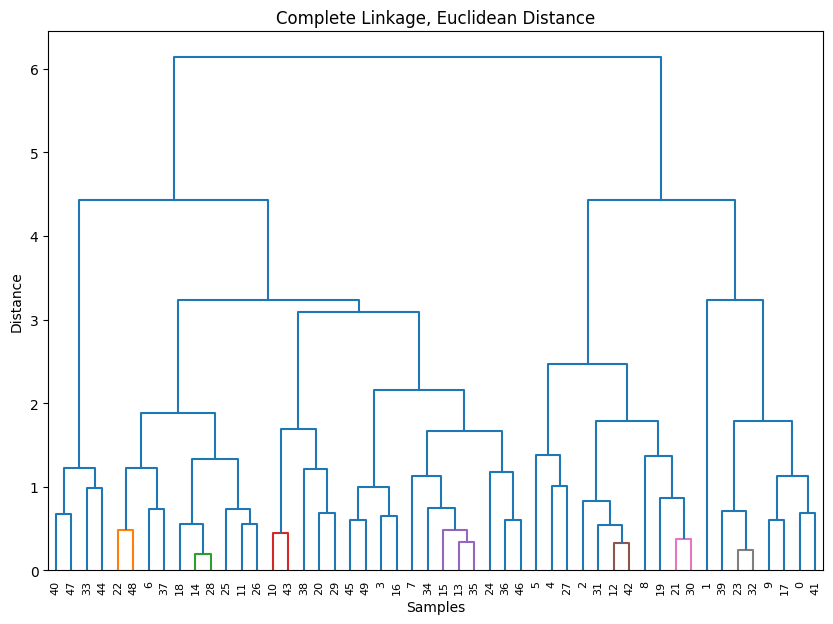

In [23]:
# Generate dendrogram for complete linkage with Euclidean distance for better visualization
plt.figure(figsize=(10, 7))

# Perform hierarchical clustering using complete linkage and Euclidean distance
Z = linkage(X, method='complete', metric='euclidean')

# Plot the dendrogram
dendrogram(Z, color_threshold=0.5)

# Set the title and axis labels
plt.title('Complete Linkage, Euclidean Distance')
plt.xlabel('Samples')
plt.ylabel('Distance')


In [24]:
# List of cluster numbers to evaluate
cluster_numbers = [2, 3, 4]

# Iterate over the list of cluster numbers to calculate silhouette scores
for n_clusters in cluster_numbers:
    # Perform agglomerative hierarchical clustering with complete linkage and Euclidean distance
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='euclidean')
    
    # Fit the model to the scaled data and predict cluster labels
    labels = agg_clustering.fit_predict(X)
    
    # Calculate the silhouette score for the current number of clusters
    sil_score = silhouette_score(X, labels, metric='euclidean')
    
    # Output the silhouette score for the current number of clusters
    print(f"Silhouette Score for {n_clusters} clusters: {sil_score}")


Silhouette Score for 2 clusters: 0.4265110406142638
Silhouette Score for 3 clusters: 0.391550328990914
Silhouette Score for 4 clusters: 0.3135738413887403


### Assumptions:

I performed hierarchical clustering with **n_clusters = 2, 3, and 4**, and calculated the silhouette scores for each:

- **2 clusters**: A silhouette score of **0.43** suggests a **moderate** clustering quality, where the points within each cluster are relatively well-separated, although not perfect.
  
- **3 clusters**: The silhouette score drops to **0.39**, indicating a **slightly lower** clustering quality compared to 2 clusters. The separation between clusters becomes less distinct.

- **4 clusters**: The silhouette score of **0.31** shows that the clustering quality declines further, with less distinction between the clusters and more overlap.

Based on the silhouette scores, the **2-cluster solution** provides the **best-defined** clustering for this dataset. Despite the dendrogram suggesting more clusters, the data structure is more effectively captured by **2 clusters** according to the silhouette evaluation. This also aligns with the PCA results, where **PC1** and **PC2** explained the majority of the variance. The two clusters likely represent **states with high crime rates** and **states with low crime rates**, consistent with the strongest patterns captured by the first two principal components.

This interpretation is consistent with the previous results in the chat, confirming that the **2-cluster solution** is the optimal choice for further analysis.

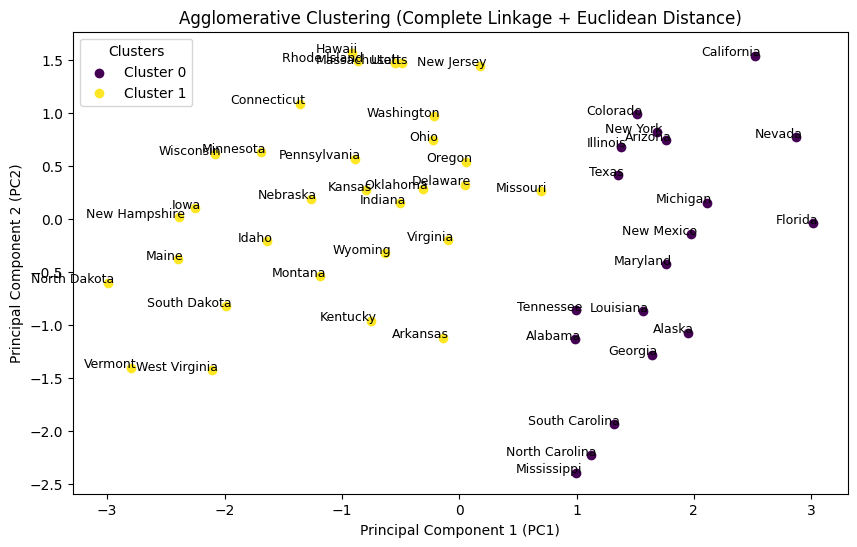

In [25]:
# Perform agglomerative hierarchical clustering with complete linkage and euclidean distance metric
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='complete', metric='euclidean')

# Fit the model to the scaled data and predict cluster labels
labels = agg_clustering.fit_predict(X)
cluster_labels = agg_clustering.fit_predict(pca_df)  # Use PCA-transformed data

# Define colors based on the number of unique clusters
unique_clusters = np.unique(cluster_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))  # Ensure color count matches cluster count

# Visualize the clusters using PCA-transformed data with state names
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the clusters using a loop to assign each cluster a different color
for i, cluster in enumerate(unique_clusters):
    subset = pca_df[cluster_labels == cluster]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1], color=colors[i], label=f'Cluster {cluster}', marker='o')

    # Add state names next to each dot
    for j in range(subset.shape[0]):
        plt.text(subset.iloc[j, 0] + 0.05, subset.iloc[j, 1], us_arrests_df['State'].iloc[cluster_labels == cluster].values[j],
                 fontsize=9, ha='right', color='black')

# Add labels and a title to describe the plot
plt.title('Agglomerative Clustering (Complete Linkage + Euclidean Distance)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Add a legend to identify each cluster
plt.legend(title='Clusters')


### Assumptions:

- **Cluster 0 (purple)**: These states tend to have **higher PC1 values** (positive), which suggests they likely have **higher overall crime rates** (Murder, Assault, Rape) based on the first principal component. The points are more spread out along PC1, reinforcing the interpretation of higher variability in crime rates within these states.
  
- **Cluster 1 (yellow)**: These states tend to have **lower PC1 values** (negative), indicating **lower overall crime rates**. The cluster is relatively more compact, suggesting less variation in crime rates among these states.

### What the Clusters Probably Represent:
- **Cluster 0** likely consists of states with **higher crime rates**, characterized by more violent crimes (Murder, Assault, and Rape).
- **Cluster 1** likely represents states with **lower crime rates**, where crime rates are relatively uniform and lower compared to Cluster 0.

This division aligns with the earlier interpretation of the principal components (PC1 and PC2), where PC1 largely captured the variation in crime rates. The clusters likely distinguish states with **high** and **low crime rates**, a pattern that was also visible in the PCA analysis.

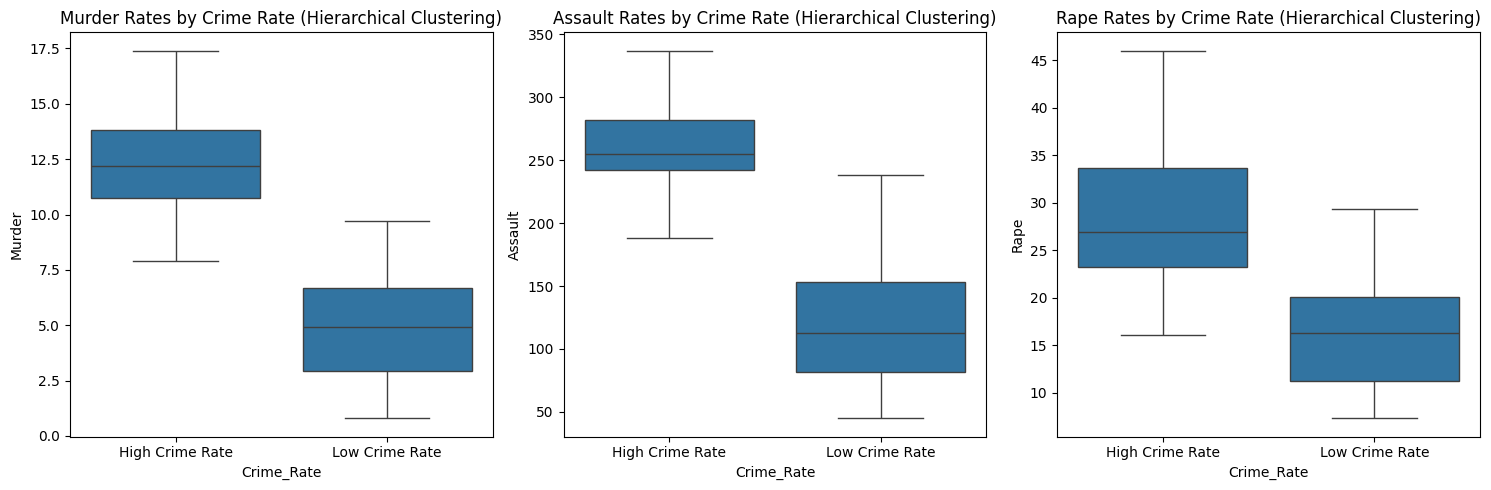

In [26]:
# Create the Crime_Rate column based on hierarchical clustering results
us_arrests_df['Crime_Rate'] = pd.Series(cluster_labels).map({0: 'High Crime Rate', 1: 'Low Crime Rate'})

# Create boxplots for Murder, Assault, and Rape by Crime Rate
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Boxplot for Murder
sns.boxplot(x='Crime_Rate', y='Murder', data=us_arrests_df, ax=ax[0])
ax[0].set_title('Murder Rates by Crime Rate (Hierarchical Clustering)')

# Boxplot for Assault
sns.boxplot(x='Crime_Rate', y='Assault', data=us_arrests_df, ax=ax[1])
ax[1].set_title('Assault Rates by Crime Rate (Hierarchical Clustering)')

# Boxplot for Rape
sns.boxplot(x='Crime_Rate', y='Rape', data=us_arrests_df, ax=ax[2])
ax[2].set_title('Rape Rates by Crime Rate (Hierarchical Clustering)')

plt.tight_layout()


### Assumptions:

The hierarchical clustering has successfully grouped states into distinct clusters based on crime rates, revealing that the "High Crime Rate" cluster consistently exhibits higher rates of murder, assault, and rape. This supports the goal of identifying patterns in crime distribution across the states.

## K-Means Clustering

c:\Users\Christen\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Christen\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


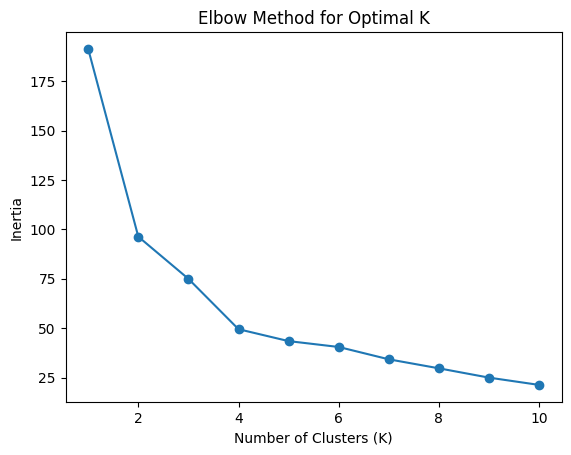

In [27]:
# Plot elbow curve
def eval_Kmeans(x, k, random_state):
    """
    Fit KMeans for a given number of clusters and return the inertia.
    
    Parameters:
    x : array-like, feature matrix
    k : int, number of clusters
    random_state : int, random seed for reproducibility
    
    Returns:
    inertia_ : float, sum of squared distances of samples to their closest cluster center
    """
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, random_state=42):
    """
    Plot the elbow curve to determine the optimal number of clusters.
    
    Parameters:
    x : array-like, feature matrix
    max_k : int, maximum number of clusters to try (default is 10)
    random_state : int, random seed for reproducibility
    
    Returns:
    None, shows a plot of inertia vs number of clusters.
    """
    within_cluster_vars = [eval_Kmeans(x, k, random_state) for k in range(1, max_k+1)]
    plt.plot(range(1, max_k + 1), within_cluster_vars, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')

# Plot elbow curve using the scaled dataset
elbow_Kmeans(X)


**Elbow Method Plot:** 
The best value for **K** is likely **3**, as it balances cluster separation while minimizing within-cluster variance.

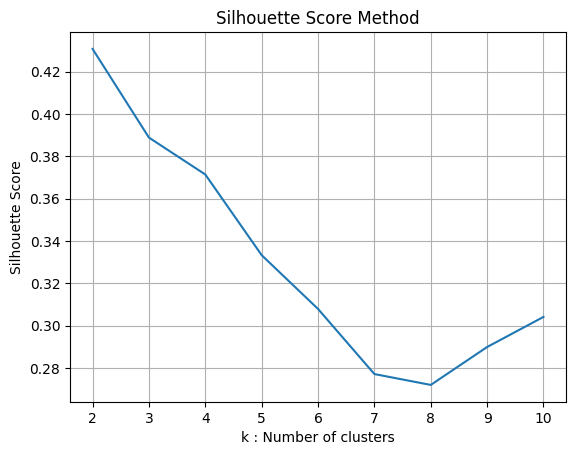

In [28]:
# Silhouette score method to evaluate KMeans clustering performance
kmax = 10
sil = []  # List to store silhouette scores

# Iterate over a range of k values to calculate silhouette scores
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=500)
    kmeans.fit(pca_df)
    labels = kmeans.labels_
    sil.append(silhouette_score(pca_df, labels, metric='euclidean'))

# Plot the silhouette scores for each k value
sns.lineplot(x=range(2, kmax + 1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()


### Assumptions:

- The **highest silhouette score** occurs at **K = 2** with a value of **0.42**, indicating the **best clustering quality**. This suggests that two clusters provide the clearest separation in the data.
  
- As **K increases**, the silhouette score steadily decreases, suggesting **diminishing clustering quality** as more clusters are introduced.

- The **elbow-like drop** after **K = 3** further supports that adding more clusters reduces the distinctness and compactness of clusters.

The **2-cluster solution** provides the most optimal separation based on silhouette score. While the **Elbow Method** suggested **K = 3** might be reasonable, the **Silhouette Score Method** reinforces that **2 clusters** are the best choice for this dataset.

In [29]:
# Define the K value based on the previous analysis
k_value = 2

# Initialize the K-Means model
kmeans = KMeans(n_clusters=k_value, random_state=42, max_iter=500)
clusters = kmeans.fit_predict(pca_df)  # This gives the cluster labels for each data point
centers = kmeans.cluster_centers_  # This gives the coordinates of the cluster centers

# Fit the model on the scaled dataset
k_fit = kmeans.fit(X)
display(k_fit)


KMeans(max_iter=500, n_clusters=2, random_state=42)

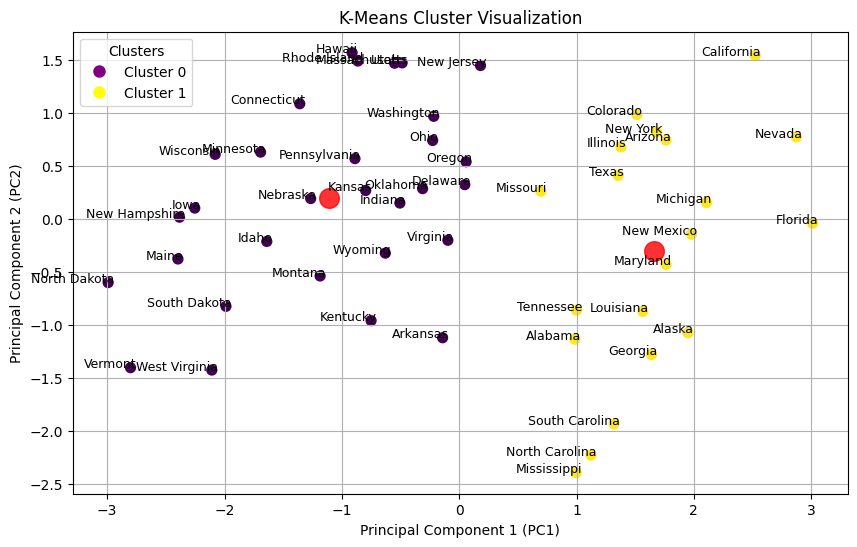

In [30]:
# Scatter plot of the data points colored by cluster label
plt.figure(figsize=(10, 6))
plt.scatter(pca_df.iloc[:, 0],
            pca_df.iloc[:, 1],
            c=clusters,
            s=50,
            cmap="viridis")

# Scatter plot of the cluster centers
plt.scatter(centers[:, 0],
            centers[:, 1],
            c="red",
            s=200,
            alpha=0.8,
            label='Cluster Centers')

# Add the state names next to each point
for i in range(pca_df.shape[0]):
    plt.text(pca_df.iloc[i, 0] + 0.05, pca_df.iloc[i, 1], us_arrests_df['State'].iloc[i],
             fontsize=9, ha='right', color='black')

# Add x and y axis labels
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Add title
plt.title('K-Means Cluster Visualization')

# Add grid
plt.grid(True)

# Add legend for clusters 0 and 1
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Cluster 0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Cluster 1')]
plt.legend(handles=handles, title='Clusters')


In [31]:
# Print the cluster centers and cluster labels
print("Cluster Centers:\n", centers)

# Count the number of records in each cluster
unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))

# Print the number of records in each cluster
print("\nNumber of records in each cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} records")


Cluster Centers:
 [[-1.10781782  0.19978289 -0.00213232]
 [ 1.66172672 -0.29967433  0.00319848]]

Number of records in each cluster:
Cluster 0: 30 records
Cluster 1: 20 records


### Assumptions:

The clustering effectively separates states into **low-crime** (Cluster 0) and **high-crime** (Cluster 1) groups, which aligns with the task objective of analyzing patterns in US crime data.

In [32]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(X, clusters, metric='euclidean')

# Print the silhouette score
print(f"Silhouette Coefficient: {silhouette_avg:.2f}")


Silhouette Coefficient: 0.43


### Assumptions:

The **moderate score** aligns with the objective of identifying patterns in crime rates. The two clusters identified by K-Means provide useful insights into **high** and **low crime states**, though there is some overlap in crime profiles between states.

In [33]:
# Add the cluster labels as a new column, renaming it to 'Crime_Rate' with descriptive labels
us_arrests_df['Crime_Rate'] = pd.Series(clusters).map({0: 'Low Crime Rate', 1: 'High Crime Rate'})

# Display a sample of the dataframe to verify the changes
us_arrests_df.sample(10)


,State,Murder,Assault,UrbanPop,Rape,Crime_Rate
7,Delaware,5.900,238,72,15.800,Low Crime Rate
46,Washington,4.000,145,73,26.200,Low Crime Rate
20,Massachusetts,4.400,149,85,16.300,Low Crime Rate
38,Rhode Island,3.400,174,87,8.300,Low Crime Rate
15,Kansas,6.000,115,66,18.000,Low Crime Rate
36,Oregon,4.900,159,67,29.300,Low Crime Rate
28,New Hampshire,2.100,57,56,9.500,Low Crime Rate
37,Pennsylvania,6.300,106,72,14.900,Low Crime Rate
40,South Dakota,3.800,86,45,12.800,Low Crime Rate
23,Mississippi,16.100,259,44,17.100,High Crime Rate


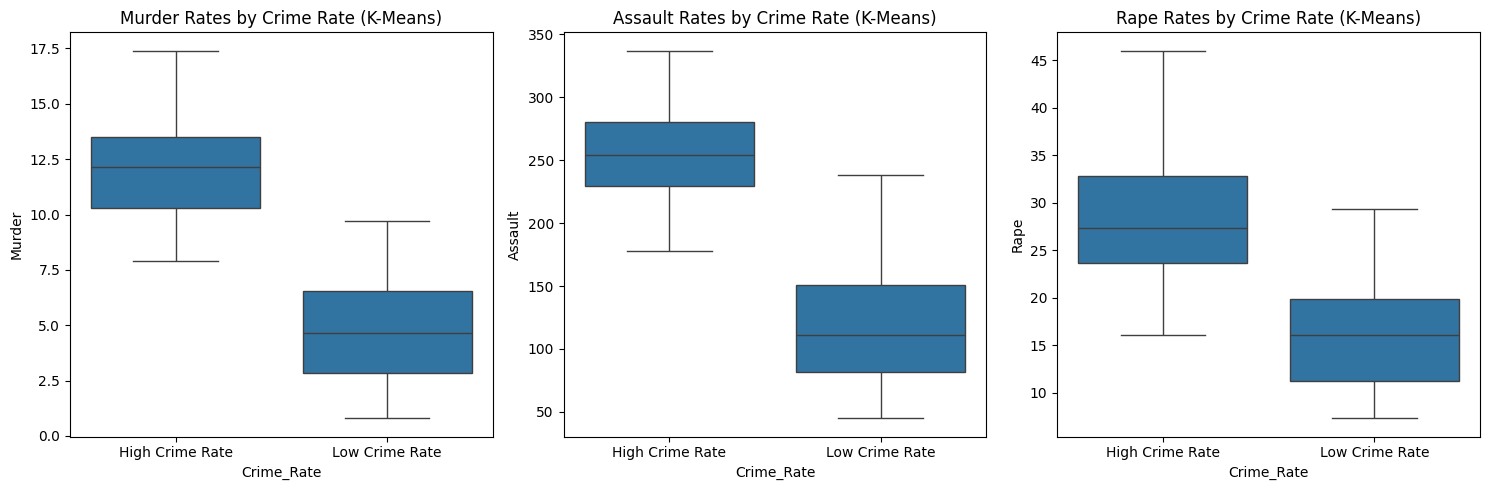

In [34]:
# Create boxplots for Murder, Assault, and Rape by Crime Rate (K-Means)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Boxplot for Murder
sns.boxplot(x='Crime_Rate', y='Murder', data=us_arrests_df, ax=ax[0])
ax[0].set_title('Murder Rates by Crime Rate (K-Means)')

# Boxplot for Assault
sns.boxplot(x='Crime_Rate', y='Assault', data=us_arrests_df, ax=ax[1])
ax[1].set_title('Assault Rates by Crime Rate (K-Means)')

# Boxplot for Rape
sns.boxplot(x='Crime_Rate', y='Rape', data=us_arrests_df, ax=ax[2])
ax[2].set_title('Rape Rates by Crime Rate (K-Means)')

plt.tight_layout()


### Assumptions:

These boxplots clearly differentiate the clusters formed by the K-Means algorithm, with the "High Crime Rate" group consistently showing higher values for murder, assault, and rape. This supports the goal of clustering states based on their crime profiles, successfully identifying meaningful patterns between high and low crime rate states.

Text(0.5, 1.02, 'Scatterplot Matrix of US Arrests Data by Crime Rate')

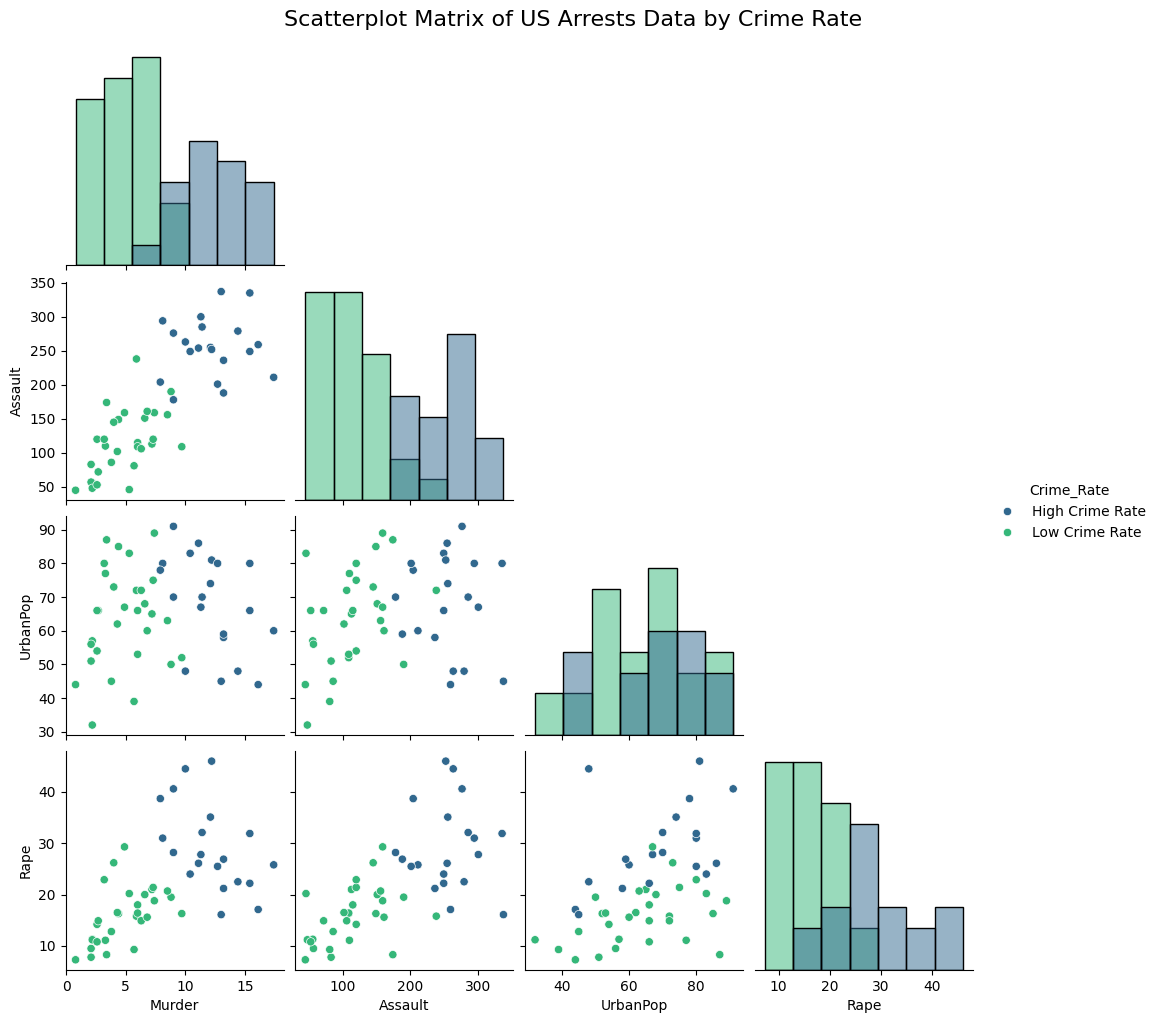

In [35]:
# Plotting a scatterplot matrix
sns.pairplot(data=us_arrests_df, hue='Crime_Rate', palette='viridis', diag_kind='hist', corner=True)

# Add a title
plt.suptitle("Scatterplot Matrix of US Arrests Data by Crime Rate", y=1.02, fontsize=16)


### Assumptions:

- The **high crime rate states** (blue) tend to have **higher values** for all crime-related variables, particularly in **Murder, Assault, and Rape**.
- **Low crime rate states** (green) generally show **lower values** across the crime variables.
- The distinction between the two clusters is most pronounced in **Assault** and **Murder**, while **UrbanPop** (urban population percentage) does not show a clear separation between the two clusters, indicating that urbanization alone is not a strong factor in separating high and low crime rate states.

## Comparison of the two methods of clustering:

1. **Agglomerative Clustering (CELL 25)**:
   - Cluster 0 (purple) contains states with higher PC1 values, indicating **higher crime rates**.
   - Cluster 1 (yellow) contains states with lower PC1 values, suggesting **lower crime rates**.
   - The clustering is more spread out, with fewer distinct cluster centers.

2. **K-Means Clustering (CELL 29)**:
   - Similar clustering pattern with most states grouped similarly to agglomerative clustering.
   - Clear cluster centers (red) are present, with K-Means focusing on tighter groupings around these centroids.
   - Just the state of **Missouri**, has shifted between clusters compared to the agglomerative method.

Both methods provide similar groupings, but **K-Means** shows more **defined cluster centers** and slightly tighter groupings. A few states are classified differently between the two methods, indicating some sensitivity to the chosen clustering approach.

### Interactive Map: Crime Rate Clusters and Detailed Crime Statistics

This interactive choropleth map visualizes **crime rate clusters** across US states, categorizing them into **high** and **low crime rate** clusters. By hovering over each state, you can explore additional crime statistics, such as **Murder, Assault, Rape**, and **UrbanPop** rates. 

The map allows for an in-depth comparison of crime patterns across states, with **red** representing states with high crime rates and **green** representing states with low crime rates. This visual representation helps uncover geographic trends and provides insights into which states have higher or lower crime rates, while also highlighting the types of crimes more prevalent in specific regions.

In [36]:
# Duplicate the 'State' column to create a new column called 'state_abbrev'
us_arrests_df['state_abbrev'] = us_arrests_df['State']

# Display the first few rows of the DataFrame to confirm the duplication
display(us_arrests_df.head())


,State,Murder,Assault,UrbanPop,Rape,Crime_Rate,state_abbrev
0,Alabama,13.200,236,58,21.200,High Crime Rate,Alabama
1,Alaska,10.000,263,48,44.500,High Crime Rate,Alaska
2,Arizona,8.100,294,80,31.000,High Crime Rate,Arizona
3,Arkansas,8.800,190,50,19.500,Low Crime Rate,Arkansas
4,California,9.000,276,91,40.600,High Crime Rate,California


In [37]:
# Map state names to valid two-letter state abbreviations
state_abbrev_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Update the 'state_abbrev' column with state abbreviations
us_arrests_df['state_abbrev'] = us_arrests_df['state_abbrev'].map(state_abbrev_map)

# Display the updated DataFrame
display(us_arrests_df.head())


,State,Murder,Assault,UrbanPop,Rape,Crime_Rate,state_abbrev
0,Alabama,13.200,236,58,21.200,High Crime Rate,AL
1,Alaska,10.000,263,48,44.500,High Crime Rate,AK
2,Arizona,8.100,294,80,31.000,High Crime Rate,AZ
3,Arkansas,8.800,190,50,19.500,Low Crime Rate,AR
4,California,9.000,276,91,40.600,High Crime Rate,CA


In [38]:
def plot_choropleth_by_cluster(dataframe, color_column):
    """
    This function creates a choropleth map for clusters in a DataFrame.
    
    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - color_column: The column in the DataFrame to use for coloring the map (e.g., 'Crime_Rate').
    """
    
    # Create the choropleth map with hover data for crime rates
    fig = px.choropleth(dataframe, 
                        locations='state_abbrev', 
                        locationmode="USA-states", 
                        color=color_column, 
                        scope="usa",
                        hover_name='State',
                        hover_data=['Murder', 'Assault', 'Rape', 'UrbanPop'],  # Include additional crime rates
                        title=f"State-wise {color_column.replace('_', ' ')}",
                        color_discrete_map={"High Crime Rate": "red", "Low Crime Rate": "green"})  # Define discrete color scale
    
    # Show the plot
    fig.show()

# Plotting the choropleth based on the crime rate clusters
plot_choropleth_by_cluster(us_arrests_df, 'Crime_Rate')


# Conclusion:

This analysis of the US Arrests dataset aimed to explore crime rates across various US states by performing **Principal Component Analysis (PCA)** and comparing two clustering methods: **Agglomerative Clustering** and **K-Means Clustering**. The task's objective was to identify patterns and group states based on crime statistics.

- **Principal Component Analysis (PCA)** revealed that the first two components accounted for over **86% of the variance** in the dataset, primarily driven by **Murder, Assault, and Rape** rates, with **UrbanPop** (urban population) having less influence.
  
- **Agglomerative Clustering** and **K-Means Clustering** both separated the states into two distinct clusters:
  - **Clusters on the right** represents states with **higher crime rates**.
  - **Clusters on the left** groups states with **lower crime rates**.
  - The clustering methods largely agreed, but one state shifted between clusters depending on the method used, **Missouri**.

- The **Silhouette Coefficient** for K-Means was **0.43**, indicating a **moderate clustering quality**. This suggests that while the clusters are meaningful, there is some overlap between the crime profiles of states in different clusters.

- **Scatterplot matrices** showed a clear separation between high and low crime states, especially in **Murder**, **Assault**, and **Rape** rates. However, **UrbanPop** did not strongly differentiate between the clusters, indicating that urbanization alone does not explain crime rates.

- The high crime rate states are concentrated in the South, West, and parts of the Midwest, while the low crime rate states are more common in the North and Central US. This aligns with the clustering results where certain regions showed higher incidences of crime, particularly in categories like Murder and Assault.

### References:

https://www.kaggle.com/code/hmahida/usarrests-pca-k-means-and-agglomerative-clustering

https://rpubs.com/TaylorCastro/720203

https://www.reddit.com/r/MLQuestions/comments/1d1w19g/should_clustering_come_first_then_dimensionality/

https://www.linkedin.com/advice/3/how-does-pca-simplify-data-clustering-skills-data-analytics-dwfhf#:~:text=To%20apply%20PCA%20for%20clustering%2C%20first%20perform%20PCA%20on%20the,more%20distinct%20and%20meaningful%20clusters.

https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests

https://www.statology.org/scree-plot-python/

https://www.jcchouinard.com/python-pca-biplots-machine-learning/

https://statisticsbyjim.com/basics/bimodal-distribution/

https://www.scaler.com/topics/matplotlib/plotting-multiple-bar-chart/

https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/

https://www.geeksforgeeks.org/choropleth-maps-using-plotly-in-python/

https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-text-files/format-text-with-markdown-jupyter-notebook/

https://islp.readthedocs.io/en/latest/datasets/USArrests.html

https://rdrr.io/r/datasets/USArrests.html

https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests
